<a href="https://colab.research.google.com/github/aditya-shriwastava/colab-notebooks/blob/master/FasterRCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# pip3 install

In [1]:
!pip3 install pytest
!pip3 install ipytest

     |████████████████████████████████| 280 kB 32.4 MB/s 
  Attempting uninstall: pluggy
    Found existing installation: pluggy 0.7.1
    Uninstalling pluggy-0.7.1:
      Successfully uninstalled pluggy-0.7.1
  Attempting uninstall: pytest
    Found existing installation: pytest 3.6.4
    Uninstalling pytest-3.6.4:
      Successfully uninstalled pytest-3.6.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


# imports


In [2]:
import random

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.optim import Adam
import torchvision

import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

from tqdm import tqdm, trange

import ipytest
ipytest.autoconfig()

import pytest

# bbox utils

In [3]:
def filter_cross_boundary(bboxs, bbox_within):
  """
  Args:
    bboxs: bboxs tensor in minmax format of shape (N,4) to filter.
    bbox_within: bbox tensor in minmax format of shape (4,) within
    which bboxs should be.
  Returns:
    A tensor of index of bboxs which are within bbox_within.
  """
  N = bboxs.shape[0]
  corner_offset = bboxs - bbox_within
  iswithin = torch.logical_and(
    (corner_offset[:,:2] >= 0).all(axis=1),
    (corner_offset[:,2:] <= 0).all(axis=1)
  )
  return torch.arange(N)[iswithin]

def filter_iou(bboxs1, bboxs2, min_iou=0, max_iou=1):
  """
  Args:
    bboxs1: bboxs tensor in xyxy format of shape (N,4)
    bboxs2: bboxs tensor in xyxy format of shape (M,4)
  Returns:
    A tensor of index of bboxs1 such that min_iou <= iou(bboxs[i], bboxs2) <= max_iou
    for i in [1,2, ..., N] and argmax_i(iou(bboxs[i], bboxs2))
  """
  N = bboxs1.shape[0]
  iou_max = torchvision.ops.box_iou(bboxs1, bboxs2).max(axis=1)[0]
  iswithin = torch.logical_and(
    (iou_max >= min_iou),
    (iou_max <= max_iou)
  )
  return torch.arange(N)[iswithin]

def sample_bboxs(bboxs, max_bboxs):
  N = bboxs.shape[0]
  if N > max_bboxs:
    index = random.sample(range(N),max_bboxs)
    return torch.tensor(index)
  else:
    return torch.arange(N)

def get_bboxs(bboxs_offset, anchors):
  """Reff https://arxiv.org/pdf/1506.01497.pdf eq2
  Args:
    bboxs_offset: tensor of shape (N,4) representing offset of bboxs in
      ctrwh format form anchors.
    anchors: tensor of shape (N,4) representing anchors in ctrwh format
  Returns:
    A tensor of shape (N,4) representing bboxs
  """
  bboxs = torch.zeros_like(bboxs_offset)

  bboxs[:,0] = anchors[:,0] + (bboxs_offset[:,0] * anchors[:,2])
  bboxs[:,1] = anchors[:,1] + (bboxs_offset[:,1] * anchors[:,3])
  bboxs[:,2] = anchors[:,2] * torch.exp(bboxs_offset[:,2])
  bboxs[:,3] = anchors[:,3] * torch.exp(bboxs_offset[:,3])
  return bboxs

def get_bboxs_offset(bboxs, anchors):
  """Reff https://arxiv.org/pdf/1506.01497.pdf eq2
  Args:
    bboxs: tensor of shape (N,4) representing bboxs in ctrwh format.
    anchors: tensor of shape (N,4) representing anchors in ctrwh format
  Returns:
    A tensor of shape (N,4) representing bboxs_offset
  """
  bboxs_offset = torch.zeros_like(bboxs)

  bboxs_offset[:,0] = (bboxs[:,0] - anchors[:,0]) / anchors[:,2]
  bboxs_offset[:,1] = (bboxs[:,1] - anchors[:,1]) / anchors[:,3]
  bboxs_offset[:,2] = torch.log(bboxs[:,2] / anchors[:,2])
  bboxs_offset[:,3] = torch.log(bboxs[:,3] / anchors[:,3])
  return bboxs_offset

def get_anchors(
    Hf, Wf,
    ratios = torch.tensor([0.5, 1.0, 2.0]),
    scale = torch.tensor([4.0, 8.0, 16.0]),
    base_size = 16,
    stride = 10):
  """
  Args:
    Hf: Height of feature_map we want anchors for.
    Wf: Width of feature_map we want anchors for.
    ratios: tensor of shape (3,) representing aspect ratios of anchors.
    scale: tensor of shape (3,) representing scale of anchors.
    base_size: base size of the anchor which will be scaled.
    stride: distance by which anchors will be shifted along height and
      weidth of feature_map.
  Returns:
    A tensor of shape (Hf*Wf*9,4) representing 9 anchors in cxcywh format at
    each pixel position.
  """
  def get_base_anchors(ratios, scale, base_size):
    """
    Args:
      ratios: tensor of shape (3,) representing aspect ratios of anchors.
      scale: tensor of shape (3,) representing scale of anchors.
      base_size: base size of the anchor which will be scaled.
    Returns:
      A tensor of shape (9,4) representing 9 anchors (3 ratios * 3 scale)
      in cxcywh format.
    """
    # 1. base_anchors(1,4) in ctrwh format
    base_anchors = torch.tensor([[
      (base_size-1)/2,
      (base_size-1)/2,
      base_size,
      base_size
    ]])

    # 2. Apply ratios to base_anchors(1,4) to generate base_anchors(3,4)
    size = base_anchors[0,2] * base_anchors[0,3]
    base_anchors = base_anchors.repeat(3,1)
    heights = torch.sqrt(size * ratios)
    widths = heights/ratios
    base_anchors[:,2] = heights
    base_anchors[:,3] = widths

    # 3. Apply scale to base_anchors(3,4) to generate base_anchors(9,4)
    base_anchors = base_anchors.repeat(1,3).view(9,4)
    base_anchors[:,2:4] *= scale.repeat(3).view(9,1).repeat(1,2)

    return torch.round(base_anchors)

  anchors = get_base_anchors(ratios, scale, base_size)\
    .view(-1)\
    .unsqueeze(0).repeat(Wf,1)\
    .unsqueeze(0).repeat(Hf,1,1)\
    .view(Hf,Wf,9,4)

  shift_x = (torch.arange(0, Wf) * stride).repeat(Hf,1)\
    .repeat(9,1,1).permute(1,2,0)
  shift_y = (torch.arange(0, Hf) * stride).unsqueeze(1).repeat(1,Wf)\
    .repeat(9,1,1).permute(1,2,0)

  anchors[:,:,:,0] += shift_x
  anchors[:,:,:,1] += shift_y

  return anchors.reshape(-1,4)

## test bbox utils

In [4]:
%%ipytest

class TestFilterCrossBoundary:
  @pytest.fixture
  def bboxs(self):
    bboxs = torch.tensor([
        [0, 0, 99, 99],
        [50, 50, 99, 99],
        [-10, 10, 20, 34],
        [10, -10, 20, 34],
        [0, 0, 0, 0],
        [99, 99, 99, 99],
        [0, 0, 199, 199],
    ], dtype=torch.float32)
    return bboxs

  def test(self, bboxs):
    bbox_within = torch.tensor([0, 0, 99, 99])
    iswithin = torch.tensor(
      [True, True, False, False, True, True, False]
    )
    index = filter_cross_boundary(bboxs, bbox_within)
    assert (bboxs[index]- bboxs[iswithin]).mean() < 0.01

class TestFilterIou:
  @pytest.fixture
  def bboxs1(self):
    bboxs1 = torch.tensor([
        [0, 0, 99, 99],
        [50, 50, 99, 99],
        [75, 25, 124, 74],
        [75, 75, 124, 124],
        [75, -25, 124, 24]
    ], dtype=torch.float32)
    return bboxs1

  @pytest.fixture
  def bboxs2(self):
    bboxs2 = torch.tensor([
        [0, 0, 99, 99],
        [50, 50, 99, 99]
    ], dtype=torch.float32)
    return bboxs2

  # torchvision.ops.box_iou(bboxs1, bboxs2)
  #   [[1.0000, 0.2450],
  #    [0.2450, 1.0000],
  #    [0.1067, 0.1363],
  #    [0.0495, 0.1363],
  #    [0.0495, 0.0000]])

  def test_case1(self, bboxs1, bboxs2):
    index = filter_iou(bboxs1, bboxs2, min_iou=0, max_iou=1)
    iswithin = torch.tensor(
      [True, True, True, True, True]
    )
    assert (bboxs1[index] - bboxs1[iswithin]).mean() < 0.01

  def test_case2(self, bboxs1, bboxs2):
    index = filter_iou(bboxs1, bboxs2, min_iou=0.1)
    iswithin = torch.tensor(
      [True, True, True, True, False]
    )
    assert (bboxs1[index] - bboxs1[iswithin]).mean() < 0.01

  def test_case3(self, bboxs1, bboxs2):
    index = filter_iou(bboxs1, bboxs2, max_iou=0.5)
    iswithin = torch.tensor(
      [False, False, True, True, True]
    )
    print(index)
    assert (bboxs1[index] - bboxs1[iswithin]).mean() < 0.01

class TestSampleBboxs:
  @pytest.fixture
  def bboxs(self):
    bboxs = torch.tensor([
        [0, 0, 99, 99],
        [50, 50, 99, 99],
        [-10, 10, 20, 34],
        [10, -10, 20, 34],
        [0, 0, 0, 0],
        [99, 99, 99, 99],
        [0, 0, 199, 199],
    ], dtype=torch.float32)
    return bboxs

  def test_case1(self, bboxs):
    index = sample_bboxs(bboxs, max_bboxs=3)
    assert index.shape[0] == 3

  def test_case2(self, bboxs):
    index = sample_bboxs(bboxs, max_bboxs=10)
    assert index.shape[0] == bboxs.shape[0]

class TestGetAnchors:
  def test(self):
    anchors = get_anchors(2,3)
    print(anchors)
    assert anchors.shape == (9*6,4)

.......                                                                                      [100%]
7 passed in 0.21s


# voc utils

In [5]:
import torch

voc_labels = ("background",
  "aeroplane", "bicycle", "bird", "boat","bottle",
  "bus", "car", "cat", "chair", "cow",
  "diningtable", "dog", "horse", "motorbike", "person",
  "pottedplant", "sheep", "sofa", "train", "tvmonitor"
)

voc_label_to_id = {k: v for v, k in enumerate(voc_labels)}

def get_bboxs_and_labels(meta):
  objects = meta['annotation']['object']
  bboxs = []
  labels = []
  ids = []
  for object_ in objects:
    labels.append(object_['name'][0])
    ids.append(voc_label_to_id[labels[-1]])
    xmin = int(object_['bndbox']['xmin'][0])
    ymin = int(object_['bndbox']['ymin'][0])
    xmax = int(object_['bndbox']['xmax'][0])
    ymax = int(object_['bndbox']['ymax'][0])
    bboxs.append([xmin, ymin, xmax, ymax])
  return torch.tensor(bboxs, dtype=torch.float32), labels, torch.tensor(ids, dtype=torch.int64)

# Load VOC data

In [6]:
train_data = torchvision.datasets.VOCDetection(
  root="./datasets", year="2012",
  image_set='train', download=True,
  transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
  ])
)
train_loader = DataLoader(train_data, batch_size=1, shuffle=True)

val_data = torchvision.datasets.VOCDetection(
  root="./datasets", year="2012",
  image_set='val', download=True,
  transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
  ])
)
val_loader = DataLoader(val_data, batch_size=1, shuffle=False)

  0%|          | 0/1999639040 [00:00<?, ?it/s]

Extracting ./datasets/VOCtrainval_11-May-2012.tar to ./datasets
Using downloaded and verified file: ./datasets/VOCtrainval_11-May-2012.tar
Extracting ./datasets/VOCtrainval_11-May-2012.tar to ./datasets


## Show sample train data

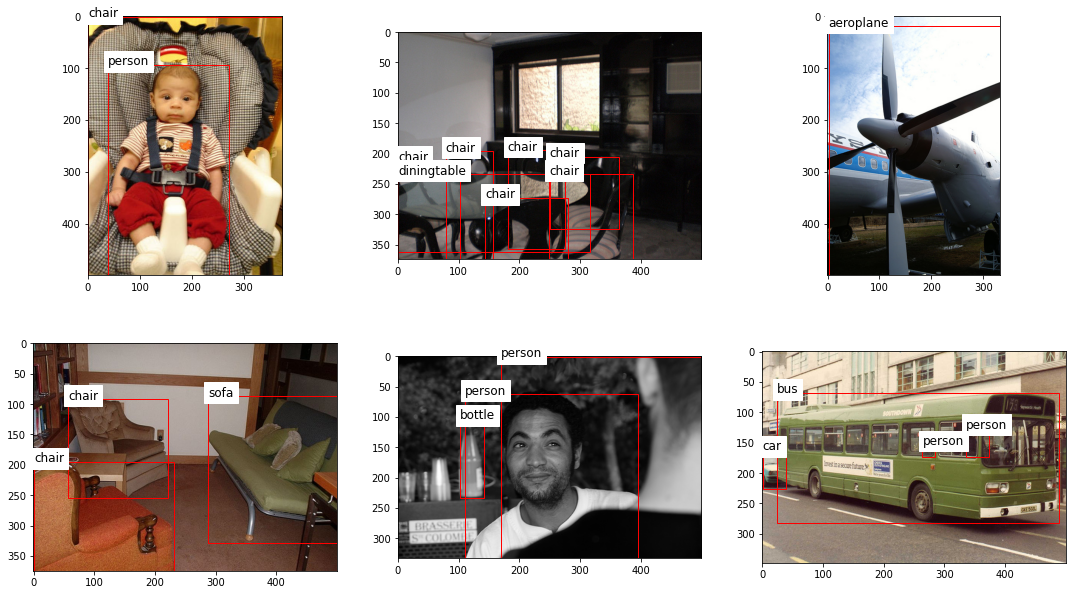

In [7]:
def disp(img, bboxs, labels, ax=None):
  img = torchvision.transforms.ToPILImage()(img)
  if ax is None:
    fig, ax = plt.subplots()
  ax.imshow(img)
  for bbox, label in zip(bboxs, labels):
    bbox = torchvision.ops.box_convert(
      bbox.unsqueeze(0),
      in_fmt='xyxy',
      out_fmt='xywh'
    ).squeeze()
    ax.add_patch(patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=1, edgecolor='r', facecolor='none'))
    ax.text(bbox[0], bbox[1], label, fontsize = 12, color='black', backgroundcolor='white')
  if ax is None:
    plt.show()

fig, axarr = plt.subplots(2,3)
fig.set_size_inches(18.5, 10.5)
for index, (img, meta) in enumerate(train_loader):
  i = index // 3
  j = index - (i * 3)
  bboxs, labels, ids = get_bboxs_and_labels(meta)
  disp(img[0], bboxs, labels, ax=axarr[i,j])
  if index == 5:
    break
plt.show()

# RPN

In [ ]:
class RPN(nn.Module):
  def __init__(self, feature_map_channels):
    super().__init__()
    self.lower_dim_mapping = nn.Sequential(
        nn.Conv2d(feature_map_channels, 512, 3, stride=1, padding=1),
        nn.ReLU()
    )
    self.objectness_score = nn.Conv2d(512, 9*2, 1, stride=1, padding=0)
    self.rois_offset= nn.Conv2d(512, 9*4, 1, stride=1, padding=0)
    self.reg_loss = nn.SmoothL1Loss()
    self.cls_loss = nn.CrossEntropyLoss()
    
  def forward(self, feature_map, image_boundaries, bboxs_gt=None):
    """
    Args:
      feature_map: tensor of shape (1, Cf, Hf, Wf).
      image_boundaries: tupel (H, W) giving the boundaries of image.
      bboxs_gt: tensor of shape (M,4) in xyxy format representing
        M ground truth bboxs on the image corresponding to the given
        feature_map.
    Returns:
      rois: tensor of shape (N,4) representing predicted rois within the image
        in xyxy format.
      reg_loss: regression loss returned only during training.
      cls_loss: classification loss returned only during training.
    """
    H, W = image_boundaries
    Hf, Wf = feature_map.shape[2:]

    # 1. forward pass
    feature_map = self.lower_dim_mapping(feature_map) 
    objectness_score = self.objectness_score(feature_map)
    rois_offset = self.rois_offset(feature_map)

    # 2. reshape
    objectness_score = objectness_score.view(9*2,Hf,Wf).permute((1,2,0)).reshape(-1,2)
    rois_offset = rois_offset.view(9*4,Hf,Wf).permute((1,2,0)).reshape(-1,4)

    # 3. get anchors
    anchors = get_anchors(Hf,Wf)

    # 4. get rois (in xyxy format) from rois_offset.
    rois = get_bboxs(rois_offset, anchors)
    rois = torchvision.ops.box_convert(rois, in_fmt='cxcywh', out_fmt='xyxy')

    # 5. Filter out rois using NMS whith iou threshold: 0.6 and select top 500
    index = torchvision.ops.batched_nms(
      rois,
      objectness_score[:,1],
      torch.zeros(Hf*Wf*9),
      iou_threshold = 0.6
    )[:500]

    # 6. Clip rois to image boundaries
    """
    Edge case:
      1. What if some bbox is compleatly outside image boundary.?
      2. What if for some bboxs clipped version is degenerate ?
        (i.e. very small, very thin etc.)
    """
    rois_clipped = torchvision.ops.clip_boxes_to_image(
      rois[index],
      image_boundaries
    )

    if not self.training:
      return rois_clipped
    else:
      ## 1. Filter out rois which goes beyond the boundaries of image.
      """
      Edge case:
        1. what if every thing is filtered out?
      """
      index = filter_cross_boundary(
        rois,
        torch.tensor([0, 0, H, W], dtype=torch.float32)
      )

      ## 2. Based on iou of rois with bboxs_gt classify rois
      #     into positive and negative.
      index_positive = index[torch.hstack((
        filter_iou(rois[index], bboxs_gt, min_iou=0.5),
        torchvision.ops.box_iou(
          rois[index],
          bboxs_gt).max(axis=1)[0].max(axis=0)[1]
      ))]
      index_negative = index[filter_iou(rois[index], bboxs_gt, max_iou=0.1)]

      ## 3. Sample 256 rois with #rois_positive/#rois_negative
      #     as close to 1 a possible.
      index_positive = index[sample_bboxs(
        rois[index_positive],
        max_bboxs = 128
      )]

      index_negative = index[sample_bboxs(
        rois[index_negative],
        max_bboxs = 256 - index_positive.shape[0]
      )]

      ## 4. Calculate cls_loss
      target = torch.hstack((
        torch.zeros(index_negative.shape[0], dtype=torch.long),
        torch.ones(index_positive.shape[0], dtype=torch.long)    
      ))
      objectness_score_training = torch.vstack((
        objectness_score[index_negative],
        objectness_score[index_positive]
      ))
      cls_loss = self.cls_loss(
          objectness_score_training,
          target
      )

      ## 5. Calculate index_positive_gt
      index_positive_gt = torchvision.ops.box_iou(
        rois[index_positive],
        bboxs_gt
      ).max(axis=1)[1]

      ## 6. Calculate reg_loss
      reg_loss = self.reg_loss(
        rois_offset[index_positive],
        get_bboxs_offset(
          torchvision.ops.box_convert(
            bboxs_gt[index_positive_gt],
            in_fmt='xyxy',
            out_fmt='cxcywh'
          ),
          anchors[index_positive]
        )
      )

      return rois_clipped,reg_loss, cls_loss

# Fast RCNN

In [ ]:
class FastRCNN(nn.Module):
  def __init__(self, feature_map_channels):
    super().__init__()
    self.fc = nn.Sequential(
      nn.Linear(feature_map_channels*7*7, 512),
      nn.ReLU(),
      nn.Linear(512, 512),
      nn.ReLU()
    )
    self.cls_score = nn.Linear(512, 21)
    self.detections_offset = nn.Linear(512, 21 * 4)
    self.reg_loss = nn.SmoothL1Loss()
    self.cls_loss = nn.CrossEntropyLoss()

  def forward(self, rois, feature_map, image_boundaries, gt=None):
    """
    Args:
      rois: tensor of shape (N,4) representing region of interests within the 
        image in xyxy format.
      feature_map: tensor of shape (1, Cf, Hf, Wf).
      image_boundaries: tupel (H, W) giving the boundaries of image.
      gt: tuple (bboxs_gt, labels_gt)
        bboxs_gt: tensor of shape (M,4) in xyxy format representing
          M ground truth bboxs on the image corresponding to the given
          feature_map.
        labels_gt: tensor of shape (M,) representing labels corresponding to
          bboxs_gt.
    Returns (During Training):
      reg_loss: regression loss
      cls_loss: classification loss
    Returns (During Evaluation):
      detections: tensor of shape (L,4) representing L detections on the
        image corresponding to the feature_map.
      labels: tensor of shape (L,) representing predicted labels corresponding
      to detections.
    """
    H, W = image_boundaries
    Cf, Hf, Wf = feature_map.shape[1:]

    # 1. ROI Projection
    rois_proj = rois * torch.tensor([Wf/W,Hf/H,Wf/W,Hf/H])
    
    # 2. ROI Pooling
    rois_fm = torchvision.ops.roi_pool(
      feature_map,
      [rois_proj],
      7
    ).reshape(-1,Cf*7*7)

    # 3. forward pass
    rois_fm = self.fc(rois_fm)
    cls_score = self.cls_score(rois_fm)
    detections_offset = self.detections_offset(rois_fm).reshape(-1,21,4)

    if self.training:
      bboxs_gt = gt['bboxs_gt']
      labels_gt = gt['labels_gt']
      
      ## 1. Based on iou of rois with bboxs_gt classify rois into
      #     positive and negative.
      index_positive = filter_iou(rois, bboxs_gt, min_iou=0.5)
      index_negative = filter_iou(rois, bboxs_gt, min_iou=0.1, max_iou=0.5)

      ## 2. Randomly sample a mini batch of size 64 in which we have up to
      #     25% positive and 75% negative.
      index_positive = index_positive[sample_bboxs(
        rois[index_positive],
        max_bboxs = 16
      )]

      index_negative = index_negative[sample_bboxs(
        rois[index_negative],
        max_bboxs = 64 - index_positive.shape[0]
      )]

      ## 3. Calculate index_positive_gt
      index_positive_gt = torchvision.ops.box_iou(
        rois[index_positive],
        bboxs_gt
      ).max(axis=1)[1]

      ## 4. Calculate cls_loss
      target = torch.hstack((
        torch.zeros(index_negative.shape[0], dtype=torch.long),
        labels_gt[index_positive_gt]    
      ))
      cls_score_training = torch.vstack((
        cls_score[index_negative],
        cls_score[index_positive]
      ))
      cls_loss = self.cls_loss(
          cls_score_training,
          target
      )

      ## 6. Calculate reg_loss
      reg_loss = self.reg_loss(
        detections_offset[index_positive][
          torch.arange(len(index_positive)),
          labels_gt[index_positive_gt]
        ],
        get_bboxs_offset(
          torchvision.ops.box_convert(
            bboxs_gt[index_positive_gt],
            in_fmt='xyxy',
            out_fmt='cxcywh'
          ),
          rois[index_positive]
        )    
      )

      return reg_loss, cls_loss
    else:
      ## 1. Obtain detections and labels with max cls score
      scores, labels = cls_score.max(dim=1)
      detections = get_bboxs(
        detections_offset[
          torch.arange(len(detections_offset)),
          labels
        ],
        rois
      )

      ## 2. Filter out detections with background as label
      index = torch.arange(len(detections))[labels != 0]

      ## 3. Apply class based NMS to filter out overlapping detections
      index = index[torchvision.ops.batched_nms(
        detections[index],
        scores[index],
        labels[index],
        iou_threshold = 0.6
      )]

      ## 4. Filter out detections that has probability below 0.8
      index = index[F.softmax(cls_score[index], dim=1).max(dim=1)[0] > 0.8]

      ## 5. clip detections to image_boundaries
      detections_clipped = torchvision.ops.clip_boxes_to_image(
        detections[index],
        image_boundaries
      )

      return detections_clipped, labels[index]

# Faster RCNN

In [ ]:
class FasterRCNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.resnet50 = torchvision.models.resnet50(pretrained=True)
    self.backbone = nn.Sequential(
      self.resnet50.conv1,
      self.resnet50.bn1,
      self.resnet50.relu,
      self.resnet50.maxpool,
      self.resnet50.layer1,
      self.resnet50.layer2,
      self.resnet50.layer3
    )

    feature_map_channels = 1024
    self.rpn = RPN(feature_map_channels)
    self.rcnn = FastRCNN(feature_map_channels)
    
  def forward(self, img, gt=None):
    """
    Args:
      img: tensor of shape (1,C,H,W) representing 1 image
      gt: A dict with keys bboxs_gt and labels_gt.
        gt['bboxs_gt']: tensor of shape (M,4) in xyxy format representing
          M ground truth bboxs on the image corresponding to the given
          feature_map.
        gt['labels_gt']: tensor of shape (M,) representing labels corresponding
          to bboxs_gt.
    """
    image_boundaries = img.shape[2:]

    # 0. Set Mode
    if self.training:
      self.rpn.train()
      self.rcnn.train()
    else:
      self.rpn.eval()
      self.rcnn.eval()
    
    # 1. Pre-Process
    if self.training:
      img, gt['bboxs_gt'] = self.preprocess(img, gt['bboxs_gt'])
    else:
      img = self.preprocess(img)[0]

    # 2. Pass img to resnet50 backbone
    feature_map = self.backbone(img)

    # 3. RPN forward pass
    if self.training:
      rois, rpn_reg_loss, rpn_cls_loss = self.rpn(
        feature_map, image_boundaries, bboxs_gt=gt['bboxs_gt'])
    else:
      rois = self.rpn(feature_map, image_boundaries)

    # 4. FastRCNN forward pass
    if self.training:
      rcnn_reg_loss, rcnn_cls_loss = self.rcnn(rois, feature_map, image_boundaries, gt=gt)
    else:
      detections, labels = self.rcnn(rois, feature_map, image_boundaries)

    # 5. Return
    if self.training:
      return rpn_reg_loss, rpn_cls_loss, rcnn_reg_loss, rcnn_cls_loss
    else:
      return detections, labels

  def preprocess(self, img, bboxs_gt=None):
    # 1. Resize the Image 
    _, _, H, W = img.shape
    img = torchvision.transforms.Resize(300)(img)

    # 2. Resize the bboxs according to image resize
    if bboxs_gt is not None:
      _, _, H_, W_ = img.shape
      bboxs_gt = bboxs_gt * torch.tensor([W_/W, H_/H, W_/W, H_/H], dtype=torch.float32)

    # 3. Normalize the the image
    normalize = torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    img = normalize(img)

    return img, bboxs_gt

# Trainer

In [ ]:
def train(model, train_loader, optimizer):
  model.train()
  train_losses = []
  tqdm_train_loader = tqdm(train_loader)
  for img, meta in tqdm_train_loader:
    bboxs, labels, ids = get_bboxs_and_labels(meta)
    optimizer.zero_grad()
    loss = model(img, {'bboxs_gt': bboxs, 'labels_gt': ids})
    loss = loss[0] + loss[1]
    loss.backward()
    optimizer.step()
    tqdm_train_loader.set_description(f"loss: {loss}")
    train_losses.append(loss.item())
  return train_losses
        
def train_epochs(model, train_loader, train_args):
  lr = train_args["lr"]
  epochs = train_args["epochs"]
  optimizer = Adam(model.parameters(), lr=lr)
  
  train_losses = []
  for epoch in range(epochs):
    print(f"epoch: {epoch+1}")
    train_losses.extend(train(model, train_loader, optimizer))
  return train_losses

# Training

In [ ]:
model = FasterRCNN()
train_losses, test_losses = train_epochs(model, train_loader, {'lr': 1e-3, 'epochs': 1})

epoch: 1


  0%|          | 0/5717 [00:00<?, ?it/s]

1856


loss: 1.7539546489715576:   0%|          | 1/5717 [00:03<5:03:39,  3.19s/it]

2000


loss: 1.4701982736587524:   0%|          | 2/5717 [00:06<4:43:40,  2.98s/it]

1972


loss: 0.9374557733535767:   0%|          | 3/5717 [00:08<4:24:28,  2.78s/it]

1928


loss: 0.8540961742401123:   0%|          | 4/5717 [00:11<4:32:20,  2.86s/it]

1610


loss: 0.6320130825042725:   0%|          | 5/5717 [00:14<4:20:53,  2.74s/it]

653


loss: 1.960815191268921:   0%|          | 6/5717 [00:18<5:08:38,  3.24s/it]

1145


loss: 2.151498794555664:   0%|          | 7/5717 [00:21<5:00:00,  3.15s/it]

1085


loss: 1.0740621089935303:   0%|          | 8/5717 [00:24<4:52:34,  3.07s/it]

942


loss: 0.6916784048080444:   0%|          | 9/5717 [00:26<4:42:16,  2.97s/it]

938


loss: 0.79411780834198:   0%|          | 10/5717 [00:29<4:35:35,  2.90s/it]

805


loss: 0.6639706492424011:   0%|          | 11/5717 [00:32<4:34:07,  2.88s/it]

955


loss: 0.8261486291885376:   0%|          | 12/5717 [00:34<4:23:06,  2.77s/it]

690


loss: 1.3191229104995728:   0%|          | 13/5717 [00:37<4:23:04,  2.77s/it]

674


loss: 0.5617724061012268:   0%|          | 14/5717 [00:40<4:14:13,  2.67s/it]

602


loss: 0.3636634349822998:   0%|          | 15/5717 [00:42<4:16:32,  2.70s/it]

443


loss: 0.5129602551460266:   0%|          | 16/5717 [00:45<4:21:23,  2.75s/it]

556


loss: 0.3747884929180145:   0%|          | 17/5717 [00:48<4:14:35,  2.68s/it]

452


loss: 0.3743031919002533:   0%|          | 18/5717 [00:50<4:10:32,  2.64s/it]

591


loss: 0.8453032970428467:   0%|          | 19/5717 [00:53<4:16:36,  2.70s/it]

358


loss: 0.6455374956130981:   0%|          | 20/5717 [00:56<4:10:31,  2.64s/it]

102


loss: 0.3312934637069702:   0%|          | 21/5717 [00:58<4:06:57,  2.60s/it]

253


loss: 0.15193963050842285:   0%|          | 22/5717 [01:01<4:03:30,  2.57s/it]

99


loss: 2.3212172985076904:   0%|          | 23/5717 [01:03<4:02:29,  2.56s/it]

119


loss: 0.5942549705505371:   0%|          | 24/5717 [01:06<4:19:13,  2.73s/it]

167


loss: 0.6999185085296631:   0%|          | 25/5717 [01:09<4:25:49,  2.80s/it]

198


loss: 0.7400978207588196:   0%|          | 26/5717 [01:12<4:30:10,  2.85s/it]

381


loss: 1.1833322048187256:   0%|          | 27/5717 [01:15<4:36:45,  2.92s/it]

585


loss: 1.811071515083313:   0%|          | 28/5717 [01:18<4:31:17,  2.86s/it]

754


loss: 1.617788314819336:   1%|          | 29/5717 [01:21<4:17:00,  2.71s/it]

861


loss: 1.4087028503417969:   1%|          | 30/5717 [01:23<4:21:33,  2.76s/it]

1042


loss: 1.1109641790390015:   1%|          | 31/5717 [01:26<4:22:55,  2.77s/it]

898


loss: 0.8020321130752563:   1%|          | 32/5717 [01:29<4:30:33,  2.86s/it]

991


loss: 1.4616217613220215:   1%|          | 33/5717 [01:32<4:36:25,  2.92s/it]

1001


loss: 0.5036975145339966:   1%|          | 34/5717 [01:35<4:28:37,  2.84s/it]

919


loss: 0.8020282983779907:   1%|          | 35/5717 [01:38<4:22:52,  2.78s/it]

799


loss: 0.7033002376556396:   1%|          | 36/5717 [01:40<4:19:39,  2.74s/it]

563


loss: 0.6391608715057373:   1%|          | 37/5717 [01:43<4:15:56,  2.70s/it]

442


loss: 1.6469734907150269:   1%|          | 38/5717 [01:45<4:12:59,  2.67s/it]

486


loss: 0.35195502638816833:   1%|          | 39/5717 [01:48<4:20:44,  2.76s/it]

567


loss: 1.645755410194397:   1%|          | 40/5717 [01:51<4:17:52,  2.73s/it]

452


loss: 3.7505221366882324:   1%|          | 41/5717 [01:54<4:15:47,  2.70s/it]

830


loss: 0.38002723455429077:   1%|          | 42/5717 [01:57<4:22:27,  2.77s/it]

959


loss: 0.6377337574958801:   1%|          | 43/5717 [01:59<4:18:41,  2.74s/it]

1095


loss: 0.5835855007171631:   1%|          | 44/5717 [02:02<4:16:22,  2.71s/it]

1094


loss: 1.0184191465377808:   1%|          | 45/5717 [02:05<4:14:22,  2.69s/it]

1067


loss: 1.2633609771728516:   1%|          | 46/5717 [02:07<4:12:09,  2.67s/it]

902


loss: 1.1026471853256226:   1%|          | 47/5717 [02:10<4:12:09,  2.67s/it]

853


loss: 1.2249064445495605:   1%|          | 48/5717 [02:13<4:12:29,  2.67s/it]

1044


loss: 1.0338289737701416:   1%|          | 49/5717 [02:15<4:10:09,  2.65s/it]

1231


loss: 1.7383794784545898:   1%|          | 50/5717 [02:18<4:09:32,  2.64s/it]

750


loss: 1.1589672565460205:   1%|          | 51/5717 [02:21<4:14:04,  2.69s/it]

774


loss: 0.8069418668746948:   1%|          | 52/5717 [02:24<4:20:53,  2.76s/it]

1214


loss: 0.6145185828208923:   1%|          | 53/5717 [02:26<4:16:26,  2.72s/it]

726


loss: 1.1318504810333252:   1%|          | 54/5717 [02:29<4:22:56,  2.79s/it]

905


loss: 0.42865902185440063:   1%|          | 55/5717 [02:32<4:20:28,  2.76s/it]

1191


loss: 0.9357762336730957:   1%|          | 56/5717 [02:34<4:18:02,  2.73s/it]

951


loss: 0.9479772448539734:   1%|          | 57/5717 [02:37<4:25:24,  2.81s/it]

1335


loss: 0.835665225982666:   1%|          | 58/5717 [02:40<4:21:51,  2.78s/it]

1202


loss: 0.898370623588562:   1%|          | 59/5717 [02:43<4:14:51,  2.70s/it]

1178


loss: 0.9970964193344116:   1%|          | 60/5717 [02:45<4:16:19,  2.72s/it]

573


loss: 0.8947408199310303:   1%|          | 61/5717 [02:48<4:10:50,  2.66s/it]

757


loss: 1.5412185192108154:   1%|          | 62/5717 [02:51<4:20:18,  2.76s/it]

1299


loss: 0.9296619296073914:   1%|          | 63/5717 [02:54<4:17:16,  2.73s/it]

726


loss: 0.9021726846694946:   1%|          | 64/5717 [02:57<4:23:26,  2.80s/it]

1188


loss: 1.1090648174285889:   1%|          | 65/5717 [02:59<4:20:48,  2.77s/it]

1053


loss: 1.2634780406951904:   1%|          | 66/5717 [03:02<4:13:11,  2.69s/it]

1254


loss: 1.242973804473877:   1%|          | 67/5717 [03:05<4:21:10,  2.77s/it]

643


loss: 1.2393841743469238:   1%|          | 68/5717 [03:08<4:26:45,  2.83s/it]

474


loss: 1.0047430992126465:   1%|          | 69/5717 [03:11<4:31:12,  2.88s/it]

647


loss: 0.8808329105377197:   1%|          | 70/5717 [03:14<4:34:52,  2.92s/it]

787


loss: 2.4326181411743164:   1%|          | 71/5717 [03:16<4:30:39,  2.88s/it]

725


loss: 1.163588047027588:   1%|▏         | 72/5717 [03:19<4:31:24,  2.88s/it]

966


loss: 1.5474107265472412:   1%|▏         | 73/5717 [03:22<4:25:42,  2.82s/it]

1129


loss: 1.2543355226516724:   1%|▏         | 74/5717 [03:25<4:20:25,  2.77s/it]

1281


loss: 0.9945513606071472:   1%|▏         | 75/5717 [03:27<4:17:06,  2.73s/it]

1259


loss: 0.767424464225769:   1%|▏         | 76/5717 [03:30<4:19:12,  2.76s/it]

1513


loss: 0.9092079401016235:   1%|▏         | 77/5717 [03:33<4:17:17,  2.74s/it]

1676


loss: 0.9059917330741882:   1%|▏         | 78/5717 [03:36<4:15:04,  2.71s/it]

1218


loss: 0.8789256811141968:   1%|▏         | 79/5717 [03:39<4:24:06,  2.81s/it]

1571


loss: 0.9075385332107544:   1%|▏         | 80/5717 [03:41<4:18:57,  2.76s/it]

1574


loss: 0.9288429021835327:   1%|▏         | 81/5717 [03:44<4:13:52,  2.70s/it]

1487


loss: 0.8719915747642517:   1%|▏         | 82/5717 [03:46<4:09:47,  2.66s/it]

1751


loss: 1.0266215801239014:   1%|▏         | 83/5717 [03:49<4:08:13,  2.64s/it]

1540


loss: 1.0285367965698242:   1%|▏         | 84/5717 [03:52<4:07:45,  2.64s/it]

1610


loss: 0.91062331199646:   1%|▏         | 85/5717 [03:54<4:02:56,  2.59s/it]

1122


loss: 1.2189480066299438:   2%|▏         | 86/5717 [03:57<4:13:57,  2.71s/it]

1679


loss: 1.8628289699554443:   2%|▏         | 87/5717 [03:59<4:07:50,  2.64s/it]

1035


loss: 1.0169117450714111:   2%|▏         | 88/5717 [04:02<4:14:04,  2.71s/it]

1328


loss: 0.8542228937149048:   2%|▏         | 89/5717 [04:04<3:55:55,  2.52s/it]

1596


loss: 0.8600978255271912:   2%|▏         | 90/5717 [04:07<3:55:57,  2.52s/it]

1691


loss: 0.8546998500823975:   2%|▏         | 91/5717 [04:09<3:55:32,  2.51s/it]

1144


loss: 0.9562150239944458:   2%|▏         | 92/5717 [04:12<4:08:03,  2.65s/it]

706


loss: 1.1145223379135132:   2%|▏         | 93/5717 [04:16<4:27:38,  2.86s/it]

1393


loss: 1.1087976694107056:   2%|▏         | 94/5717 [04:18<4:19:19,  2.77s/it]

798


loss: 0.8253567218780518:   2%|▏         | 95/5717 [04:21<4:24:04,  2.82s/it]

1394


loss: 0.8837121725082397:   2%|▏         | 96/5717 [04:24<4:21:58,  2.80s/it]

1468


loss: 0.8637596368789673:   2%|▏         | 97/5717 [04:26<4:08:02,  2.65s/it]

121


loss: 0.9199475049972534:   2%|▏         | 98/5717 [04:29<4:17:19,  2.75s/it]

950


loss: 0.9024268388748169:   2%|▏         | 99/5717 [04:32<4:14:27,  2.72s/it]

1113


loss: 0.6899267435073853:   2%|▏         | 100/5717 [04:35<4:20:58,  2.79s/it]

907


loss: 0.8263505101203918:   2%|▏         | 101/5717 [04:38<4:21:33,  2.79s/it]

1294


loss: 0.8305226564407349:   2%|▏         | 102/5717 [04:40<4:13:19,  2.71s/it]

1292


loss: 0.7079041004180908:   2%|▏         | 103/5717 [04:43<4:08:03,  2.65s/it]

1068


loss: 0.9220619797706604:   2%|▏         | 104/5717 [04:45<3:50:38,  2.47s/it]

746


loss: 0.7613544464111328:   2%|▏         | 105/5717 [04:48<4:04:54,  2.62s/it]

1106


loss: 0.9412953853607178:   2%|▏         | 106/5717 [04:50<4:00:53,  2.58s/it]

757


loss: 0.7303464412689209:   2%|▏         | 107/5717 [04:53<4:12:01,  2.70s/it]

963


loss: 0.9404236674308777:   2%|▏         | 108/5717 [04:56<4:12:02,  2.70s/it]

1168


loss: 0.8459291458129883:   2%|▏         | 109/5717 [04:59<4:11:21,  2.69s/it]

1040


loss: 0.8937889337539673:   2%|▏         | 110/5717 [05:02<4:21:08,  2.79s/it]

1475


loss: 0.9306051731109619:   2%|▏         | 111/5717 [05:04<4:16:36,  2.75s/it]

1361


loss: 1.6338355541229248:   2%|▏         | 112/5717 [05:07<4:22:52,  2.81s/it]

1190


loss: 0.9262266159057617:   2%|▏         | 113/5717 [05:10<4:21:54,  2.80s/it]

1460


loss: 0.8404543399810791:   2%|▏         | 114/5717 [05:13<4:19:31,  2.78s/it]

898


loss: 0.8649088144302368:   2%|▏         | 115/5717 [05:17<4:56:56,  3.18s/it]

1103


loss: 1.2263462543487549:   2%|▏         | 116/5717 [05:20<4:45:35,  3.06s/it]

1063


loss: 0.7608979940414429:   2%|▏         | 117/5717 [05:22<4:23:45,  2.83s/it]

1163


loss: 0.7172632217407227:   2%|▏         | 118/5717 [05:24<4:15:02,  2.73s/it]

663


loss: 0.8172788619995117:   2%|▏         | 119/5717 [05:27<4:25:45,  2.85s/it]

829


loss: 0.729149341583252:   2%|▏         | 120/5717 [05:30<4:18:50,  2.77s/it]

169


loss: 1.2777421474456787:   2%|▏         | 121/5717 [05:34<4:49:17,  3.10s/it]

861


loss: 1.141371250152588:   2%|▏         | 122/5717 [05:36<4:32:42,  2.92s/it]

1176


loss: 1.9765613079071045:   2%|▏         | 123/5717 [05:39<4:19:30,  2.78s/it]

1243


loss: 0.7221531867980957:   2%|▏         | 124/5717 [05:41<4:11:10,  2.69s/it]

832


loss: 1.3715568780899048:   2%|▏         | 125/5717 [05:44<4:14:10,  2.73s/it]

778


loss: 1.1043908596038818:   2%|▏         | 126/5717 [05:47<4:19:26,  2.78s/it]

983


loss: 0.8626868724822998:   2%|▏         | 127/5717 [05:50<4:12:53,  2.71s/it]

1619


loss: 0.8456201553344727:   2%|▏         | 128/5717 [05:52<4:05:19,  2.63s/it]

1167


loss: 0.881531298160553:   2%|▏         | 129/5717 [05:55<4:04:43,  2.63s/it]

1158


loss: 1.0551612377166748:   2%|▏         | 130/5717 [05:58<4:08:36,  2.67s/it]

1083


loss: 0.9521246552467346:   2%|▏         | 131/5717 [06:00<4:12:29,  2.71s/it]

1082


loss: 0.8126422166824341:   2%|▏         | 132/5717 [06:03<4:15:44,  2.75s/it]

1457


loss: 0.9119579792022705:   2%|▏         | 133/5717 [06:06<4:22:03,  2.82s/it]

1442


loss: 0.9804264307022095:   2%|▏         | 134/5717 [06:09<4:18:46,  2.78s/it]

1660


loss: 0.8242508172988892:   2%|▏         | 135/5717 [06:11<4:06:18,  2.65s/it]

1443


loss: 0.7572504281997681:   2%|▏         | 136/5717 [06:14<4:10:06,  2.69s/it]

1745


loss: 0.8874296545982361:   2%|▏         | 137/5717 [06:17<4:10:51,  2.70s/it]

1789


loss: 0.9700612425804138:   2%|▏         | 138/5717 [06:19<4:13:06,  2.72s/it]

1152


loss: 1.069810152053833:   2%|▏         | 139/5717 [06:23<4:25:06,  2.85s/it]

1301


loss: 0.8434951305389404:   2%|▏         | 140/5717 [06:26<4:35:17,  2.96s/it]

1335


loss: 0.9320761561393738:   2%|▏         | 141/5717 [06:29<4:33:07,  2.94s/it]

1191


loss: 0.8395419120788574:   2%|▏         | 142/5717 [06:32<4:39:52,  3.01s/it]

1474


loss: 0.7922998666763306:   3%|▎         | 143/5717 [06:35<4:34:45,  2.96s/it]

1041


loss: 1.0600924491882324:   3%|▎         | 144/5717 [06:38<4:42:31,  3.04s/it]

1248


loss: 0.8218954205513:   3%|▎         | 145/5717 [06:41<4:36:10,  2.97s/it]

586


loss: 0.81220543384552:   3%|▎         | 146/5717 [06:44<4:53:21,  3.16s/it]

1334


loss: 0.5860913991928101:   3%|▎         | 147/5717 [06:47<4:32:30,  2.94s/it]

1460


loss: 0.8966610431671143:   3%|▎         | 148/5717 [06:50<4:27:52,  2.89s/it]

378


loss: 1.0568455457687378:   3%|▎         | 149/5717 [06:53<4:44:57,  3.07s/it]

685


loss: 1.9997787475585938:   3%|▎         | 150/5717 [06:56<4:45:58,  3.08s/it]

626


loss: 0.6137894988059998:   3%|▎         | 151/5717 [06:59<4:44:57,  3.07s/it]

928


loss: 0.7886942625045776:   3%|▎         | 152/5717 [07:02<4:30:41,  2.92s/it]

588


loss: 1.2754932641983032:   3%|▎         | 153/5717 [07:05<4:37:49,  3.00s/it]

511


loss: 0.777651846408844:   3%|▎         | 154/5717 [07:08<4:39:02,  3.01s/it]

371


loss: 1.2359603643417358:   3%|▎         | 155/5717 [07:11<4:32:55,  2.94s/it]

478


loss: 0.8191342949867249:   3%|▎         | 156/5717 [07:14<4:28:27,  2.90s/it]

680


loss: 0.996045708656311:   3%|▎         | 157/5717 [07:16<4:16:03,  2.76s/it]

164


loss: 0.7322391271591187:   3%|▎         | 158/5717 [07:19<4:23:02,  2.84s/it]

454


loss: 0.7513471245765686:   3%|▎         | 159/5717 [07:22<4:35:11,  2.97s/it]

615


loss: 0.5805305242538452:   3%|▎         | 160/5717 [07:25<4:34:05,  2.96s/it]

61


loss: 0.7415704131126404:   3%|▎         | 161/5717 [07:28<4:33:51,  2.96s/it]

480


loss: 0.9765766859054565:   3%|▎         | 162/5717 [07:31<4:23:12,  2.84s/it]

312


loss: 0.6307913661003113:   3%|▎         | 163/5717 [07:34<4:28:11,  2.90s/it]

189


loss: 0.8861414194107056:   3%|▎         | 164/5717 [07:37<4:33:25,  2.95s/it]

308


loss: 0.558843195438385:   3%|▎         | 165/5717 [07:40<4:42:08,  3.05s/it]

289


loss: 0.5656771659851074:   3%|▎         | 166/5717 [07:43<4:47:34,  3.11s/it]

341


loss: 0.6169420480728149:   3%|▎         | 167/5717 [07:46<4:34:33,  2.97s/it]

106


loss: 0.5028941631317139:   3%|▎         | 168/5717 [07:49<4:36:10,  2.99s/it]

59


loss: 0.5621763467788696:   3%|▎         | 169/5717 [07:52<4:24:52,  2.86s/it]

109


loss: 0.36637014150619507:   3%|▎         | 170/5717 [07:54<4:15:12,  2.76s/it]

96


loss: 1.1104744672775269:   3%|▎         | 171/5717 [07:57<4:09:16,  2.70s/it]

58


loss: 0.9180959463119507:   3%|▎         | 172/5717 [08:00<4:13:50,  2.75s/it]

26


loss: 3.1511216163635254:   3%|▎         | 173/5717 [08:03<4:18:13,  2.79s/it]

0


IndexError: ignored

# Inference

# Docs

## Faster RCNN

### PreProcess
### Common
> **Input:** image, `bboxs_gt`<br/>
> **Output:** `image` (i.e. pre-processed image), `bboxs_gt` (i.e. pre-processed `bboxs_gt`)

1. Normalize the input image with mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225].
2. Rescale the normalized image such that shorter side in 300 pixels and return `image`.
3. Rescale the `bboxs_gt` according to the image rescale and return `bboxs_gt`.

### Backbone
### Common
> **Input:** `image`<br/>
> **Output:** `feature_map`, `subsampling_ratio`

1. Pass `image` to resnet50 backbone (i.e. upto layer3) and return output as `feature_map`.
2. if `image.shape` = (C,H,W) and `feature_map.shape` = (Cf,Hf,Wf) return `subsampling_ratio` as (Hf/H, Wf/W)

### RPN
#### Common
> **Input:** `feature_map`<br/>
> **Output:** `objectness_score`, `rois_offset`

1. Pass `feature_map` to 3x3 convolution to reduce depth to 512 while conserving Hf and Wf.
   - stride=1 and padding=1
   - output: `feature_map` of shape (512, Hf, Wf)
2. Pass above output to two 1x1 convolution to get `objectness_score` and `rois_offset`.
   1. `objectness_score`: (2 x 9, Hf, Wf)
     - Number of anchors: 9
     - (object score + not object score) per anchors: 2
   2. `rois_offset`: (4 x 9, Hf, Wf)
     - Number of anchors: 9
     - Number of param for roi offset of 1 anchors: 4
3. Reshape `objectness_score` and `rois_offset` to `(Hf*Wf*9,2)` and `(Hf*Wf*9,4)` respectively.

#### Training
> **Input:** `image_boundaries`, `objectness_score`, `rois_offset`, `bboxs_gt`<br/>
> **Output:** `cls_loss`, `reg_loss`

1. Filter out rois which goes beyond the boundaries of `image`.
2. Based on IoU (Intersection over Union) of rois with `bboxs_gt` classify rois into positive and negative.
    1. **Positive:** if IoU > 0.5
    2. **Negative:** if IoU < 0.1
3. Sample 256 rois with `#rois_positive/#rois_negative` as close to 1 a possible.
4. Calculate and return `cls_loss` as cross-entropy loss over objectness score with positive being object and negative not being object.
5. Calculate `rois_positive_gt = [bbox_in_gt_with_maxIoU(roi_positive, bboxs_gt) for roi_positive in rois_positive]`.
6. Calculate and return `reg_loss` as smooth L1 loss of (`rois_offset_positive` - `rois_offset_positive_gt`)

#### Inference
> **Input:** `image_boundaries`, `objectness_score`, `rois_offset`<br/>
> **Output:** `rois`

1. Sort rois based on objectness score.
2. Filter out rois using NMS whith IoU threshold: 0.6
3. Keep top N=500 proposals.
4. Clip filtered rois to `image` boundaries and return the clipped rois.

### FastRCNN
#### Common
> **Input:** rois, `feature_map`, `subsampling_ratio`<br/>
> **Output:** `classification_score`, `detections_offset`

1. Perform ROI Pooling with rois on `feature_map` and obtain `rois_fm` (rois feature map).
2. pass `rois_fm` to two fully connected layer of dimension 512.
3. Pass the output of above to two different fc layer:
    1. 21 dimensional to get `classification_score`.
    2. 21 * 4 dimensional to get `detections_offset`.

#### Training
> **Input:** `classification_score`, `detections_offset`, `bboxs_gt`, `labels_gt`<br/>
> **Output:** `cls_loss`, `reg_loss`

1. Based on IoU (Intersection over Union) of rois with `bboxs_gt` classify rois into positive and negative.
    1. **Positive:** if IoU > 0.5
    2. **Negative:** if 0.1 < IoU < 0.5
2. Randomly sample a mini batch of size 64 in which we have up to 25% positive and 75% negative.
3. Calculate
    1. `detections_positive_gt_bboxs = [bbox_in_gt_with_maxIoU(detection_positive, bboxs_gt) for detection_positive in detections_positive]`
    2. `detections_positive_gt_labels = [labels_with_maxIoU(detection_positive, bboxs_gt) for detection_positive in detections_positive]` 
5. Calculate and return `cls_loss` as cross-entropy loss over `classification_score` with positive being object with `detections_positive_gt_labels` as labels and negative being background.
6. Calculate and return `reg_loss` as smooth L1 loss of (`detection_offset_positive` - `detection_offset_positive_gt_bboxs`)

#### Inference
> **Input:** `image_boundaries`, `classification_score`, `detections_offset`<br/>
> **Output:** detections, labels

1. Obtain detections with max classification score.
2. Filter out detections in which background has max classification score.
3. Apply class based NMS.
    1. Group the detections by class
    2. Sort them by probability.
    3. Apply NMS to each group independently.
4. Filter out detections that has probability below a certain threshold.
5. clip detections to `image_boundaries`.

### FasterRCNN
#### Training
> **Input:** image, `bboxs_gt`, `labels_gt`<br/>
> **Output:** `rpn_cls_loss`, `rpn_reg_loss`, `rcnn_cls_loss`, `rcnn_reg_loss`

1. `image, bboxs_gt = PreProcess.Common(image, bboxs_gt)`
2. `feature_map, subsampling_ratio = Backbone.Common(image)`
3. `objectness_score, rois_offset = RPN.Common(feature_map)`
4. `rpn_cls_loss, rpn_reg_loss = RPN.Training(image.shape[2:], objectness_score, rois_offset, bboxs_gt)`
5. `rois = RPN.Inference(image.shape[2:], objectness_score, rois_offset)`
6. `classification_score, detections_offset = FastRCNN.Common(rois, feature_map, subsampling_ratio)`
7. `rcnn_cls_loss, rcnn_reg_loss = FasterRCNN.Training(classification_score, detections_offset, bboxs_gt, labels_gt)`

#### Inference
> **Input:** image<br/>
> **Output:** detections, labels

1. `image, bboxs_gt = PreProcess.Common(image, bboxs_gt)`
2. `feature_map, subsampling_ratio = Backbone.Common(image)`
3. `objectness_score, rois_offset = RPN.Common(feature_map)`
5. `rois = RPN.Inference(image.shape[2:], objectness_score, rois_offset)`
6. `classification_score, detections_offset = FastRCNN.Common(rois, feature_map, subsampling_ratio)`
7. `detections, labels = FastRCNN.Inference(image.shape[2:], classification, detections_offset)`